# Credit Scoring with Missing Data Analysis

This notebook demonstrates the analysis of credit scoring data with a focus on handling Missing Not At Random (MNAR) data. We'll compare different methods for handling missing data and evaluate their impact on model performance.

## Table of Contents
1. [Setup and Data Loading](#1.-Setup-and-Data-Loading)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Missing Data Analysis](#3.-Missing-Data-Analysis)
4. [Handling Missing Data](#4.-Handling-Missing-Data)
5. [Model Training](#5.-Model-Training)
6. [Model Evaluation](#6.-Model-Evaluation)
7. [Results Comparison](#7.-Results-Comparison)
8. [Conclusions](#8.-Conclusions)

## 1. Setup and Data Loading

First, let's import the necessary libraries and load our data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from fancyimpute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Add the 'src' directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Import our custom modules
from missing_data_handler import MissingDataHandler
from model import CreditScoringModel
from utils import preprocess_data, plot_missingness, plot_feature_distributions, create_correlation_matrix, split_data

# Set random seed for reproducibility
np.random.seed(42)


# Load the three datasets with different missing data mechanisms
data_mar = pd.read_csv('../data_mar.csv')
data_mcar = pd.read_csv('../data_mcar.csv')
data_mnar = pd.read_csv('../data_mnar.csv')
print(f"MAR Dataset shape: {data_mar.shape}")
print(f"MCAR Dataset shape: {data_mcar.shape}")
print(f"MNAR Dataset shape: {data_mnar.shape}")



## 2. Data Preprocessing

Let's examine our data and perform initial preprocessing steps.

In [ ]:
# Display basic information about the MCAR dataset
print("Dataset Info for MCAR:")
data_mcar.info()

print("\nSummary Statistics for MCAR:")
data_mcar.describe()

# Display basic information about the MAR dataset
print("Dataset Info for MAR:")
data_mar.info()

print("\nSummary Statistics for MAR:")
data_mar.describe()

# Display basic information about the MNAR dataset
print("Dataset Info for MNAR:")
data_mnar.info()

print("\nSummary Statistics for MNAR:")
data_mnar.describe()



## 3. Missing Data Analysis

Let's analyze the patterns of missing data in our dataset.

In [ ]:
# Visualize missing data patterns
plot_missingness(data_mcar, "MCAR Dataset")

# Plot feature distributions
plot_feature_distributions(data_mcar, "MCAR Dataset")

# Create correlation matrix
create_correlation_matrix(data_mcar, "MCAR Dataset")

# Visualize missing data patterns
plot_missingness(data_mar, "MAR Dataset")

# Plot feature distributions
plot_feature_distributions(data_mar, "MAR Dataset")

# Create correlation matrix
create_correlation_matrix(data_mar, "MAR Dataset")

# Visualize missing data patterns
plot_missingness(data_mnar, "MNAR Dataset")

# Plot feature distributions
plot_feature_distributions(data_mnar, "MNAR Dataset")

# Create correlation matrix
create_correlation_matrix(data_mnar, "MNAR Dataset")

## 4. Handling Missing Data

We'll apply different methods to handle missing data and create multiple versions of our dataset.

### 4.1 Functioned Handling of Missing Data --Work in progress

In [ ]:
# # Initialize missing data handler
# handler = MissingDataHandler()

# # Apply different missing data handling methods
# df_mean = handler.mean_imputation(data_mnar.copy(), 'target')
# df_heckman = handler.heckman_correction(data_mnar.copy(), 'target', 'feature_0')
# df_basl = handler.basl_method(data_mnar.copy(), 'target')


# # Store datasets in a dictionary
# datasets = {
#     'mean_imputation': df_mean,
#     'heckman_correction': df_heckman,
#     'basl_method': df_basl
# }

# # 1. Compare target distributions
# plt.figure(figsize=(15, 5))
# for idx, (method, df) in enumerate(datasets.items(), 1):
#     plt.subplot(1, 3, idx)
#     sns.countplot(data=df, x='target')
#     plt.title(f'Target Distribution - {method}')
#     plt.xlabel('Target')
#     plt.ylabel('Count')
    
#     # Add percentage labels
#     total = len(df)
#     for p in plt.gca().patches:
#         percentage = f'{100 * p.get_height()/total:.1f}%'
#         plt.gca().annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
#                           ha='center', va='bottom')
    
#     # Force x-axis to show only 0 and 1
#     plt.gca().set_xticks([0, 1])
#     plt.gca().set_xticklabels(['0', '1'])
# plt.tight_layout()
# plt.show()

# # 2. Compare feature distributions for each method
# for method, df in datasets.items():
#     print(f"\nFeature Distributions for {method}:")
#     plot_feature_distributions(df, f"{method} - MNAR Dataset")

# # 3. Compare correlation matrices
# for method, df in datasets.items():
#     print(f"\nCorrelation Matrix for {method}:")
#     create_correlation_matrix(df, f"{method} - MNAR Dataset")

# # 4. Print basic statistics for each method
# for method, df in datasets.items():
#     print(f"\nBasic Statistics for {method}:")
#     print(df.describe())

# # 5. Compare missing values
# for method, df in datasets.items():
#     print(f"\nMissing Values for {method}:")
#     print(df.isnull().sum())

### 4.2 Imputation by MICE

In [11]:
# Replace infinite values with NaN (to avoid issues)
data_mnar['target'] = data_mnar['target'].replace({np.inf: np.nan, -np.inf: np.nan})

# Separate features and target
features = data_mnar.drop(columns=['target'])
target = data_mnar['target']

# Step 1: Impute only the features (excluding target)
imputer_features = IterativeImputer(random_state=42, max_iter=50)
features_imputed = imputer_features.fit_transform(features)
features_imputed_df = pd.DataFrame(features_imputed, columns=features.columns)

# Step 2: Impute the binary target separately using Logistic Regression
target_imputer = IterativeImputer(
    estimator=LogisticRegression(class_weight="balanced"), 
    random_state=42,
    max_iter=50,
    sample_posterior=False,  
    min_value=0,
    max_value=1
)

target_reshaped = target.values.reshape(-1, 1)  # Ensure correct shape for imputation
target_imputed_nd = target_imputer.fit_transform(target_reshaped)

# Convert imputed target back to binary
target_imputed = np.round(target_imputed_nd).astype(int).flatten()

# Combine imputed features and target
data_imputed = features_imputed_df.copy()
data_imputed['target'] = target_imputed

# Save the final dataset
data_imputed.to_csv("data_mnar_mice_imputed.csv", index=False)

# Verify imputation
print("Imputation completed. Target variable distribution before MICE:")
print(target.value_counts(dropna=False))  # Include NaN counts
print("Target variable distribution after MICE:")
print(data_imputed['target'].value_counts())

Imputation completed. Target variable distribution before MICE:
target
0.0    452
1.0    337
NaN    211
Name: count, dtype: int64
Target variable distribution after MICE:
target
0    663
1    337
Name: count, dtype: int64


### 4.3 No Imputation at All

In [12]:
data_no_missing = data_mnar.dropna()

# Step 3: Separate features and target
features_no_missing = data_no_missing.drop(columns=['target'])
target_no_missing = data_no_missing['target']

# Show a summary of the data after removing missing values
print("Data after removing rows with missing values:")
print(data_no_missing.info())

# Optionally, you can save the cleaned dataset
data_no_missing.to_csv("data_no_missing.csv", index=False)

# Verify that there are no missing values
print("Target variable distribution after removing missing rows:")
print(target_no_missing.value_counts())

Data after removing rows with missing values:
<class 'pandas.core.frame.DataFrame'>
Index: 789 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_0  789 non-null    float64
 1   feature_1  789 non-null    float64
 2   feature_2  789 non-null    float64
 3   feature_3  789 non-null    float64
 4   feature_4  789 non-null    float64
 5   feature_5  789 non-null    float64
 6   feature_6  789 non-null    float64
 7   feature_7  789 non-null    float64
 8   feature_8  789 non-null    float64
 9   feature_9  789 non-null    float64
 10  target     789 non-null    float64
dtypes: float64(11)
memory usage: 74.0 KB
None
Target variable distribution after removing missing rows:
target
0.0    452
1.0    337
Name: count, dtype: int64


## 5. Model Part

Now we'll train models using each version of our dataset.

### 5.1 Loading Data and Initiating Model Class

In [13]:
# Load your datasets
data_mnar_mice = pd.read_csv("data_mnar_mice_imputed.csv")
data_mnar_no_missing = pd.read_csv("data_no_missing.csv")  # Dataset without missing values


# Initialize the model
model_mnar_mice = CreditScoringModel(random_state=42, class_weight='balanced')
model_mnar_no_missing = CreditScoringModel(random_state=42, class_weight='balanced')


# Show a summary of the data
print(data_mnar_mice.info())
print(data_mnar_no_missing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_0  1000 non-null   float64
 1   feature_1  1000 non-null   float64
 2   feature_2  1000 non-null   float64
 3   feature_3  1000 non-null   float64
 4   feature_4  1000 non-null   float64
 5   feature_5  1000 non-null   float64
 6   feature_6  1000 non-null   float64
 7   feature_7  1000 non-null   float64
 8   feature_8  1000 non-null   float64
 9   feature_9  1000 non-null   float64
 10  target     1000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 86.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_0  789 non-null    float64
 1   feature_1  789 non-null    float64
 2   feature_2  789 non-null    float64
 3   feature

### 5.2 Train-Test Split

In [14]:
target_column = 'target'


# Prepare the data (train-test split)
X_train_mnar, X_test_mnar, y_train_mnar, y_test_mnar = model_mnar_mice.prepare_data(data_mnar_mice, target=target_column)
X_train_no_missing, X_test_no_missing, y_train_no_missing, y_test_no_missing = model_mnar_no_missing.prepare_data(data_mnar_no_missing, target=target_column)

### 5.3 Model Training and Evaluation

Evaluating model with MICE imputation...


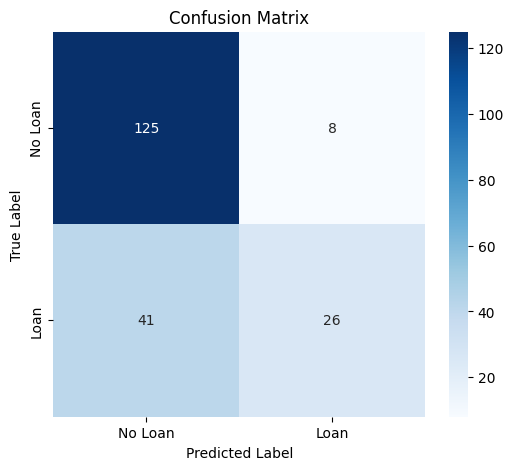


Model Performance Summary:
      Metric     Value
0   accuracy  0.755000
1  precision  0.758859
2     recall  0.663955
3   f1-score  0.675486
Evaluating model with no missing data...


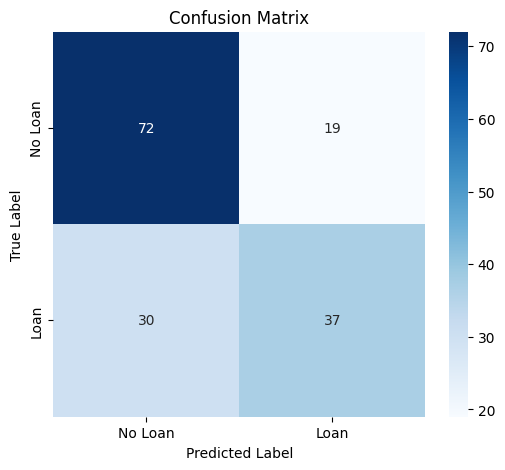


Model Performance Summary:
      Metric     Value
0   accuracy  0.689873
1  precision  0.683298
2     recall  0.671724
3   f1-score  0.673870

Comparison of Model Performance:
  Imputation Method  Accuracy  Macro Avg Precision  Macro Avg Recall  \
0   MICE Imputation  0.755000             0.758859          0.663955   
1   No Missing Data  0.689873             0.683298          0.671724   

   Macro Avg F1-Score  
0            0.675486  
1            0.673870  


In [15]:
# Train and evaluate the model with MICE imputed data
print("Evaluating model with MICE imputation...")
results_mnar = model_mnar_mice.evaluate_model(X_train_mnar, X_test_mnar, y_train_mnar, y_test_mnar)

# Train and evaluate the model with data that had missing values removed
print("Evaluating model with no missing data...")
results_no_missing = model_mnar_no_missing.evaluate_model(X_train_no_missing, X_test_no_missing, y_train_no_missing, y_test_no_missing)

# Compare results
performance_data = {
    "Imputation Method": ["MICE Imputation", "No Missing Data"],
    "Accuracy": [results_mnar['accuracy'], results_no_missing['accuracy']],
    "Macro Avg Precision": [
        results_mnar['classification_report']['macro avg']['precision'],
        results_no_missing['classification_report']['macro avg']['precision']
    ],
    "Macro Avg Recall": [
        results_mnar['classification_report']['macro avg']['recall'],
        results_no_missing['classification_report']['macro avg']['recall']
    ],
    "Macro Avg F1-Score": [
        results_mnar['classification_report']['macro avg']['f1-score'],
        results_no_missing['classification_report']['macro avg']['f1-score']
    ]
}

comparison_df = pd.DataFrame(performance_data)

print("\nComparison of Model Performance:")
print(comparison_df)